# Markov Chain Monte-Carlo 

We already know several methods of sampling the random variable with the given distribution, but each of the methods has its limitations.
Today we introduce methods of sampling r.v. with complex probability function using r.v. that we can sample easily.

But first let us introduce a concept of Markov Chains.

# Markov Chains

The sequence of r.v. $\{X_n\}$ is called (discrete-time) Markov Chain if the probability of the next state depends *only* on the previous state
$$
\mathbb P[X_n=x\mid X_1=x_1,\,X_2=x_2,\,\ldots,\,X_{n-1}=x_{n-1}]=
\mathbb P[X_n=x\mid X_{n-1}=x_{n-1}].
$$
Generation of Markov Chain is the following process
$$
\begin{align}
X_0&\sim p_0(x)\\
X_1&\sim q_0(x\mid X_0)\\
X_2&\sim q_1(x\mid X_1)\\
&\vdots\\
X_N&\sim q_{N-1}(x\mid X_{N-1})\\
\end{align}
$$
If all the functions $q_i$ are the same $q_1=q_2=\ldots=q$ then this MC is called **time-homogeneous**.

----

We want to find the appropriate $q$ so that the sample $\{X_n\}$ of the Markov Chain is the sample with the given distribution.

Let $p_N(x)$ if the (marginal) probability density of r.v. $X_n$ of the given MC, $X_n\sim p_n(x)$.
Then
$$
p_n(x)=\int q(x\mid y)p_{n-1}(y)\,dy.
$$

A distribution $\pi(x)$ is called *invariant* with respect to the Markov chain if
$$
\pi(x)=\int q(x\mid y)\pi(y)\,dy.
$$

If we want to sample from MC with the given distribution $p$ then it must be invariant.

A sufficient condition for invariance is the equation of detailed balance
$$
p(x)q(y\mid x)=
p(y)q(x\mid y)
$$
Indeed,
$$
\int q(x\mid y)p(y)\,dy=
\int q(y\mid x)p(x)\,dy=
p(x)\int q(y\mid x)\,dy=
p(x).
$$

The MC can have more than one invariant distribution.

Let $\pi$ is one of them.
If
$$
\forall p_0\colon\;\; p_n\mathop\to_{n\to\infty}\pi
$$
then this MC is **ergodic**.
Such MC has only one invariant distribution. 

A sufficient condition for MC to be ergodic is
$$
\forall x, y\colon \pi(x)\neq0\colon \;\; q(x\mid y)>0.
$$

---

So, if we want to sample from distribution $p$,
it is sufficient to require that the MC is homogeneous and ergodic and $p$ is its invariant.
Then, staring from some time moment $n$ out sample will be independent of $p_0$ and has the distribution $p$.


# Metropolis–Hastings algorithm

Let we want to sample from the probability $p$ which we know up to a constant
$$
p(x)=\frac1Z\tilde p(x).
$$
The step of Metropolis–Hastings algorithm is the following. 
Let us have the previous point $X_{n-1}$, then we generate the next point $X_*$ from the given conditional distribution,
$X_*\sim r(x\mid X_{n-1})$. 
Then we calculate 
$$
A(X_*,X_N)=
\min\left(1,\, 
\frac{\tilde p(X_*)r(X_N\mid X_*)}
{\tilde p(X_N)r(X_*\mid X_N)} \right)
$$
and we add the point $X_*$ to the sample with the probability $A$ i.e. we sample a uniformly distributed r.v. $\eta\sim\mathcal U(0,1)$ and if $\eta<A$, we accept the point.
Otherwise we just throw it away.

So, we model a new Markov Chain with the following 
transition probability
$$
q(X_{n+1}\mid X_n)=
\left\{
\begin{align} 
  r(X_{n+1}\mid X_n)A(X_{n+1}, X_n)&,& \text{ if } X_{n+1}&\neq X_n,\\
1-r(X_{n+1}\mid X_n)A(X_{n+1}, X_n)&,& \text{ if } X_{n+1}&=X_n, 
\end{align}
\right.
$$

Let us show that the distribution $p$ is invariant with respect to this new MC.
We first check the detailed balance equation
$$
p(X_n)q(X\mid X_n)=
\min\bigl[\underbrace{p(X_n)r(X\mid X_n),\,p(X)r(X_n\mid X)}_{\text{symmetric}}\bigr]=
p(X)q(X_n\mid X).
$$

---

It is sufficient to require inequality $r(x\mid y)>0$ for ergodic.

## Metropolis algorithm

Metropolis algorithm is a simple version of  Metropolis–Hastings algorithm in the case when 
$r$ is symmetric: $r(x\mid y)=r(y\mid x)$.
In this case, the expression for $A$ is simplified
$$
A(X_*,X_N)=
\min\left(1,\, 
\frac{\tilde p(X_*)}
{\tilde p(X_N)} \right).
$$
In other words, we generate a new point $X_*\sim r(x\mid X_{n-1})$ and take it, if the given probability function $\tilde p$ is grater in this point then in the previous.
Otherwise,
we take  the point with probability $\frac{\tilde p(X_*)}
{\tilde p(X_N)}$.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
from ipywidgets import interactive, interact, widgets

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'figure.dpi': 100}
matplotlib.rcParams.update(params)

In [2]:
def gen_gauss_rho(Sigma, mu=0.0):
    n = len(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    det = np.linalg.det(Sigma)
    C = ((2*np.pi)**(float(n)/2)*np.sqrt(det))

    def gauss(x):
        return np.exp(-0.5*((x-mu) @ Sigma_inv @ (x-mu)))/C

    return gauss


def gen_r(sigma=1):
    Sigma = sigma*np.eye(2)
    rho = gen_gauss_rho(Sigma, mu=0.0)

    def r(T_prev, T_new):
        return rho(T_prev - T_new)

    return r

We will illustrate the Metropolis algorithm in a simple case.
Consider 2D random variable $(\xi_1,\,\xi_2 )$ with the covariation matrix
$$
\Sigma=\pmatrix{3 & 1.5 \\ 1.5 & 1}
$$
and zero means.

We will use a random variable $\eta\sim\mathcal N(0,\sigma)$ as the distribution we will sample from.
Different values of $\sigma$ will be used.

In [3]:
def test_Metro(sigma_test=1.0, N=300):
    out_d = 1.5
    Sigma = np.array([[3, out_d], [out_d, 1]])
    rho = gen_gauss_rho(Sigma)
    r1 = gen_r(sigma_test)

    plt.figure(figsize=(15, 9))
    np.random.seed(42)
    X_cur = np.random.randn(2)*sigma_test
    plt.plot(X_cur[0], X_cur[1], 'g.', ms=10)
    num = 0
    # for _ in range(N):
    while num < N:
        X_new = np.random.randn(2)*sigma_test
        #A = min(1.0, rho(X_new)*r(X_cur, X_new)/(rho(X_cur)*r(X_new, X_cur)))
        A = min(1.0, rho(X_new)/rho(X_cur))
        if np.random.rand() < A:
            plt.plot(X_new[0], X_new[1], 'b.', ms=10)
            plt.plot([X_cur[0], X_new[0]], [X_cur[1], X_new[1]], 'b')
            X_cur = X_new
            num += 1
        else:
            plt.plot([X_cur[0], X_new[0]], [X_cur[1], X_new[1]], 'r', lw=0.3)
            plt.plot(X_new[0], X_new[1], 'r.', ms=1)

    plt.xlim([-5, 5])
    plt.ylim([-3, 3])
    plt.xlabel(r'$\xi_1$')
    plt.ylabel(r'$\xi_2$')
    plt.title('Process path with rejections')


controls = {
    'sigma_test': widgets.FloatSlider(
        min=0.2, max=3, step=0.01, value=1.0, continuous_update=False, description=r'$\sigma$'),
    'N': widgets.IntSlider(
        min=10, max=100, step=1, value=20, continuous_update=False, description='$N$')
}


In [4]:
interact(test_Metro, **controls);

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='$\\sigma$', max=3.0, min=0.2, step=0.01), IntSlider(value=20, continuous_update=False, description='$N$', min=10), Output()), _dom_classes=('widget-interact',))

We can see that large $\sigma$ values increase number of rejections, whereas small values of $\sigma$ lead to higher correlation of points.

# Gibbs Scheme

Let we want to generate a sample form multivariate distribution $p(X)$,
$X=\{x_1,\,x_2,\,\ldots,\,x_d\}$.
Let we have $X_n=\{x_1^n,\,x_2^n,\,\ldots,\,x_d^n\}$ 
In the Gibbs Scheme we 
generate the components of the next point $X_{n+1}=\{x_1^{n+1},\,x_2^{n+1},\,\ldots,\,x_d^{n+1}\}$ one after another
$$
\begin{align}
x_1^{n+1}&\sim p(x_1\mid x_2^n,\,x_3^n\,\ldots,\,x_d^n),\\
x_2^{n+1}&\sim p(x_2\mid x_1^{n+1}, \, x_3^n,\,\ldots,\,x_d^n),\\
x_3^{n+1}&\sim p(x_3\mid x_1^{n+1}, \, x_2^{n+1},\, x_4^n,\,\ldots,\,x_d^n),\\
&\vdots\\
x_d^{n+1}&\sim p(x_1\mid x_1^{n+1},\, x_2^{n+1},\, x_3^{n+1}\,\ldots,\,x_{d-1}^{n+1}).
\end{align}
$$
here $p(x_i\mid X_{\sim i})$ is marginal one-dimensional distribution of the $i^{\text{th}}$ component 
under the condition of the remaining components.

Note that on the $i^{\text{th}}$ step we use components from all the previous steps.

---
Generating one-dimensional distribution is a much simpler task than from a multivariate one.

Let us prove by induction that the distribution $p(X)$ is invariant with respect to the introduced Markov chain.  
On each step, $x_i\sim p(x_i\mid X_{\sim i})$. 
By the induction hypothesis, we have $X_{\sim i}\sim p(X_{\sim i})$. 
Then the joint configuration 
$$
(x_i,X_{\sim i})\sim p(x_i\mid X_{\sim i}) p(X_{\sim i})=p(X).
$$
So, $p$ is invariant with respect to one step of the process and hence it is invariant to the whole MC.

### Example on Gibbs Scheme

We will use 2D random variable, considered above in Metropolis scheme.
The explicit form of probability distribution of the two dependent normal random variables is 
$$
\rho(x_1,x_2)=C\exp\left(
-\frac12
\frac{x_1^2\sigma_2^2-2x_1x_2\sigma_{12}+x_2^2\sigma_1^2}
{\sigma_1^2\sigma_2^2-\sigma_{12}^2}
\right).
$$

So, the conditional density $p(x_1\mid x_2)$ of $x_1$ for a fixed value of $x_2$
has the mean value $\mu=x_2\frac{\sigma_{12}}{\sigma_2^2}$ and variance $\sigma^2=\frac{\sigma_1^2\sigma_2^2-\sigma_{12}^2}{\sigma_2^2}$.

Similarly for $x_2$.

----

Let us demonstrate iterations of Gibbs process for this r.v.

In [5]:
def cond_distrib_sample(Sigma, x2, elem=0):
    sigma1 = Sigma[elem, elem]
    sigma2 = Sigma[1 - elem, 1 - elem]
    sigma12 = Sigma[0, 1]
    mu = x2*sigma12/sigma2
    sigma = sigma1 - (sigma12**2)/sigma2
    return np.random.randn()*np.sqrt(sigma) + mu


def plot_Gibbs(N=10):
    x1 = x2 = 0.0
    out_d = 1.5
    Sigma = np.array([[3, out_d], [out_d, 1]])
    for _ in range(N):
        x1new = cond_distrib_sample(Sigma, x2, elem=0)
        plt.plot([x1, x1new], [x2, x2], 'b', lw=.3)
        plt.plot(x1new, x2, 'b.', ms=10)
        x1 = x1new

        x2new = cond_distrib_sample(Sigma, x1, elem=1)
        plt.plot([x1, x1], [x2, x2new], 'b', lw=.3)
        plt.plot(x1, x2new, 'b.', ms=10)
        x2 = x2new

    plt.xlim([-5, 5])
    plt.ylim([-3, 3])
    plt.xlabel(r'$\xi_1$')
    plt.ylabel(r'$\xi_2$')
    plt.title('Gibbs process path')

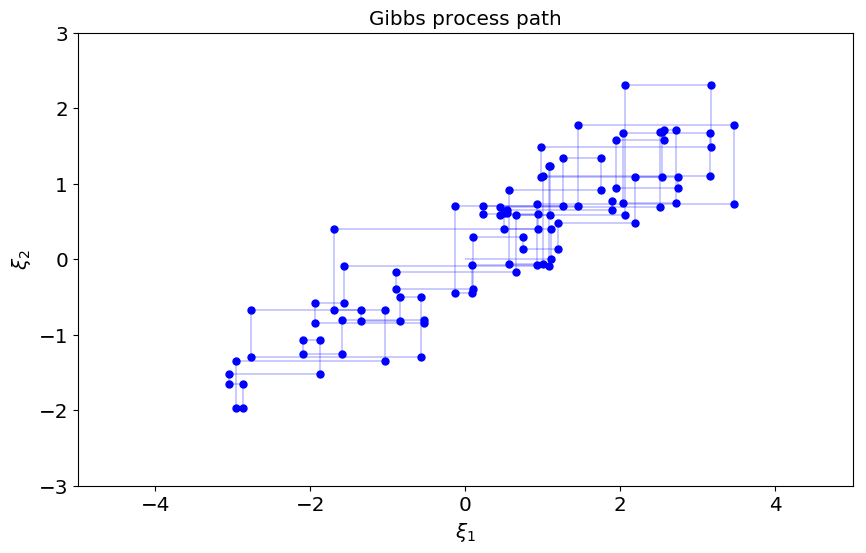

In [6]:
plot_Gibbs(50)

Let us turn to the demonstration of solving more complex problem by MCMC – parameters estimation of nonlinear model.

### Inverse problem example
In the following demonstration we will approximate the coefficients of 1D nonlinear function $f(x) = \sin(\alpha x)\cdot\cos(\beta x)$ with the use of Metropolis-Hastings algorithm. In order to do this, we will use a ```pymc``` module for MCMC routine in Python. 
* Generate $N$ points where to evaluate $f(x)$: $x = \{x_i\}_1^N\sim\mathcal{U}(-2,2)$.
* Model with a normally distributed noise: $y = f(x) = \sin(\alpha x)\cdot\cos(\beta x) + \epsilon$, where $\epsilon\sim\mathcal{N}(0,0.1)$.
* Prior on model parameters: $\alpha,\beta\sim\mathcal{U}(-5,5)$.

Samples from the chain constructed in Metropolis-Hastings algorithm are assumed to be sampled from the "right" prob distribution. But there are two issues that should be addressed during the sampling:
* At the initial samples the chain performs in a transient regime. So, the chain can be considered as ergodic only on samples with the numbers $N>N_{\text{burn}}$. In order to archive this, we need to throw away first $N_{\text{burn}}$ samples. This number can be estimated, say, with the plot of the trace. 
* Ideally, we need as independent samples as possible. Successive samples are strongly correleated (since the state of the chain doen't change if a move is rejected). To select less correlated samples, we need to throw samples in between (thinning). Autocorrelation fuctions of the process are used to select weakly correlated samples.

Brief description of the figures that are plotted below. <br>
In tuning mode:
* Plot of the trace for each parameter.
* Plot of autocorrelation for each parameter as well.
* Parameters posterior histograms.

In approximation mode:
* Plot of the model points and MCMC samples that approximate it.
* Plot of the estimating model parameters ($\alpha,\beta$).

Controls:
* $N_{\text{data}}$ – number of data points.
* $N_{\text{samples}}$ – number of MCMC samples.
* $N_{\text{burn}}$ – number of data points that will be *burn* during the transient regime.
* Thin – this parameter defines the step size in samples selection when trying to avoid autocorrelation.
* $\sigma$ – parameter of MCMC model that defines the size of the steps in Metropolis-Hastings algorithm.

In [7]:
import scipy as sp
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from pymc.Matplot import plot
import pymc


def MCMC(num_of_data, num_of_samples, burn, thin, width, mode):
    
    np.random.seed(1)
    
    x_data = -2+4*np.random.rand(num_of_data)
    y_data = np.sin(2*x_data)*np.cos(3*x_data) + 0.01*np.random.randn(num_of_data)

    alpha = pymc.Uniform('alpha', lower=-5, upper=5)
    beta = pymc.Uniform('beta', lower=-5, upper=5)

    x = pymc.Normal('x', mu=0, tau=1., value=x_data, observed=True)

    @pymc.deterministic(plot=False)
    def sincos(x=x, alpha=alpha, beta=beta):
        return np.sin(alpha*x)*np.cos(beta*x)

    y = pymc.Normal('output', mu=sincos, tau=width, value=y_data, observed=True)

    model = pymc.Model([x, y, alpha, beta])
    mcmc = pymc.MCMC(model)
    mcmc.sample(iter=num_of_samples, burn=burn, thin=thin)
    if mode == 'Tuning':
        plot(mcmc)
    else:
        f,(ax1,ax2) = plt.subplots(1,2,figsize=(18,9))
        x_pl = np.arange(-2,2,0.01)
        alpha = mcmc.trace('alpha')[::thin+5]
        beta = mcmc.trace('beta')[::thin+5]
        for i in range(len(alpha)):
            ax1.plot(x_pl, np.sin(alpha[i]*x_pl)*np.cos(beta[i]*x_pl), 'r', alpha=0.1)
        ax1.scatter(x_data,y_data) 
        ax1.set_xlabel(r'$x$')
        ax1.set_ylabel(r'$f(x)$')
        ax2.plot(alpha,beta)
        ax2.set_xlabel(r'$\alpha$')
        ax2.set_ylabel(r'$\beta$')
        plt.show()
    
controls = {
    'num_of_data': widgets.IntSlider(min=10, max=1000, step=5, value=100, continuous_update=False, description=r'$N_{\text{data}}$'),
    'num_of_samples': widgets.IntSlider(min=8000, max=100000, step=1000, value=10000, continuous_update=False, description=r'$N_{\text{samples}}$'),
    'burn': widgets.IntSlider(min=0, max=10000, step=100, value=0, continuous_update=False, description=r'$N_{\text{burn}}$'),
    'thin': widgets.IntSlider(min=1, max=100, step=5, value=2, continuous_update=False, description=r'Thin'),
    'width': widgets.FloatSlider(min=0.1, max=1.5, step=0.1, value=1., continuous_update=False, description=r'$\sigma$'),
    'mode': widgets.RadioButtons(options=['Tuning', 'Approximation'], value='Tuning', description='Mode:', disabled=False)
}        

In [8]:
interact(MCMC,**controls);

interactive(children=(IntSlider(value=100, continuous_update=False, description='$N_{\\text{data}}$', max=1000, min=10, step=5), IntSlider(value=10000, continuous_update=False, description='$N_{\\text{samples}}$', max=100000, min=8000, step=1000), IntSlider(value=0, continuous_update=False, description='$N_{\\text{burn}}$', max=10000, step=100), IntSlider(value=2, continuous_update=False, description='Thin', min=1, step=5), FloatSlider(value=1.0, continuous_update=False, description='$\\sigma$', max=1.5, min=0.1), RadioButtons(description='Mode:', options=('Tuning', 'Approximation'), value='Tuning'), Output()), _dom_classes=('widget-interact',))